In the following example, you will try to predict the vote of people during an election in the United Kingdom by knowing some information on their knowledge and political orientation.

# 0. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn import metrics
import bisect

import warnings
warnings.filterwarnings('ignore')

#  1. Reading data

In [2]:
df = pd.read_csv("data/BEPS.csv")

In [3]:
df.head()

,vote,age,economic.cond.national,economic.cond.household,Blair,Hague,Kennedy,Europe,political.knowledge,gender
0,Liberal Democrat,43,3,3,4,1,4,2,2,female
1,Labour,36,4,4,4,4,4,5,2,male
2,Labour,35,4,4,5,2,3,3,2,male
3,Labour,24,4,2,2,1,3,4,0,female
4,Labour,41,2,2,1,1,4,6,2,male


In [4]:
df.shape

(1525, 10)

In [5]:
df.describe()

,age,economic.cond.national,economic.cond.household,Blair,Hague,Kennedy,Europe,political.knowledge
count,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000,1525.000000
mean,54.182295,3.245902,3.140328,3.334426,2.746885,3.135082,6.728525,1.542295
std,15.711209,0.880969,0.929951,1.174824,1.230703,1.081997,3.297538,1.083315
min,24.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,41.000000,3.000000,3.000000,2.000000,2.000000,2.000000,4.000000,0.000000
50%,53.000000,3.000000,3.000000,4.000000,2.000000,3.000000,6.000000,2.000000
75%,67.000000,4.000000,4.000000,4.000000,4.000000,4.000000,10.000000,2.000000
max,93.000000,5.000000,5.000000,5.000000,5.000000,5.000000,11.000000,3.000000


# 2. Exploratory Data Analysis

## 2.1. Missing Values

Check if the dataset contain any missing values.

In [6]:
df.isna().sum()

vote                       0
age                        0
economic.cond.national     0
economic.cond.household    0
Blair                      0
Hague                      0
Kennedy                    0
Europe                     0
political.knowledge        0
gender                     0
dtype: int64

## 2.2. Distribution of the target variable

Plot the distribution of the target variable.

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'vote')]

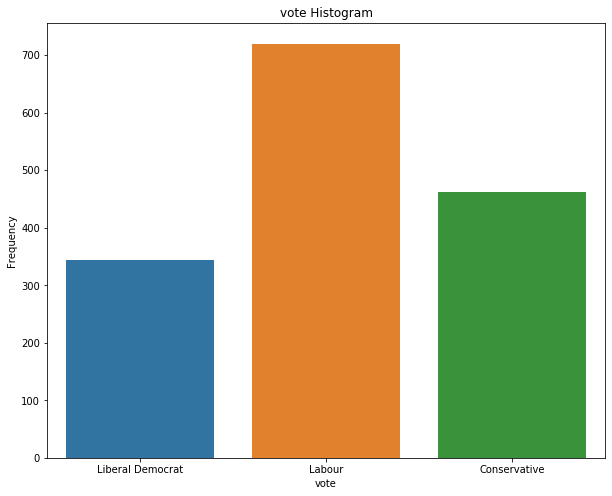

In [7]:
target_col = "vote"
plt.figure(figsize=(10, 8))

plt.title(target_col+' Histogram')
ax = sns.countplot(df.vote)
ax.set(xlabel = target_col, ylabel='Frequency')

## 2.3. Distribution of numerical variables

Plot the distribution of the numerical features.

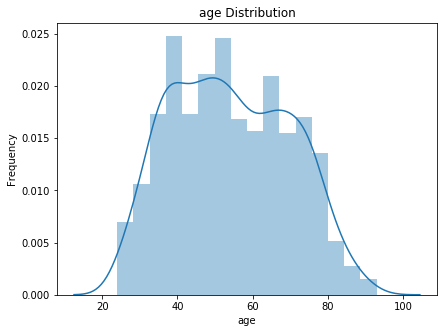

In [8]:
num_cols = ['age']
fig_rows = np.ceil(len(num_cols)/2)

plt.figure(figsize=(15, fig_rows*5))
plt.subplots_adjust(hspace=0.5)

for ind, col in enumerate(num_cols):
    plt.subplot(fig_rows,2,ind+1)
    plt.title(col+' Distribution')
    ax = sns.distplot(df[col])
    ax.set(xlabel = col, ylabel='Frequency')

## 2.4. Histogram of catagorical variables

Plot the histogram of the catagorical features.

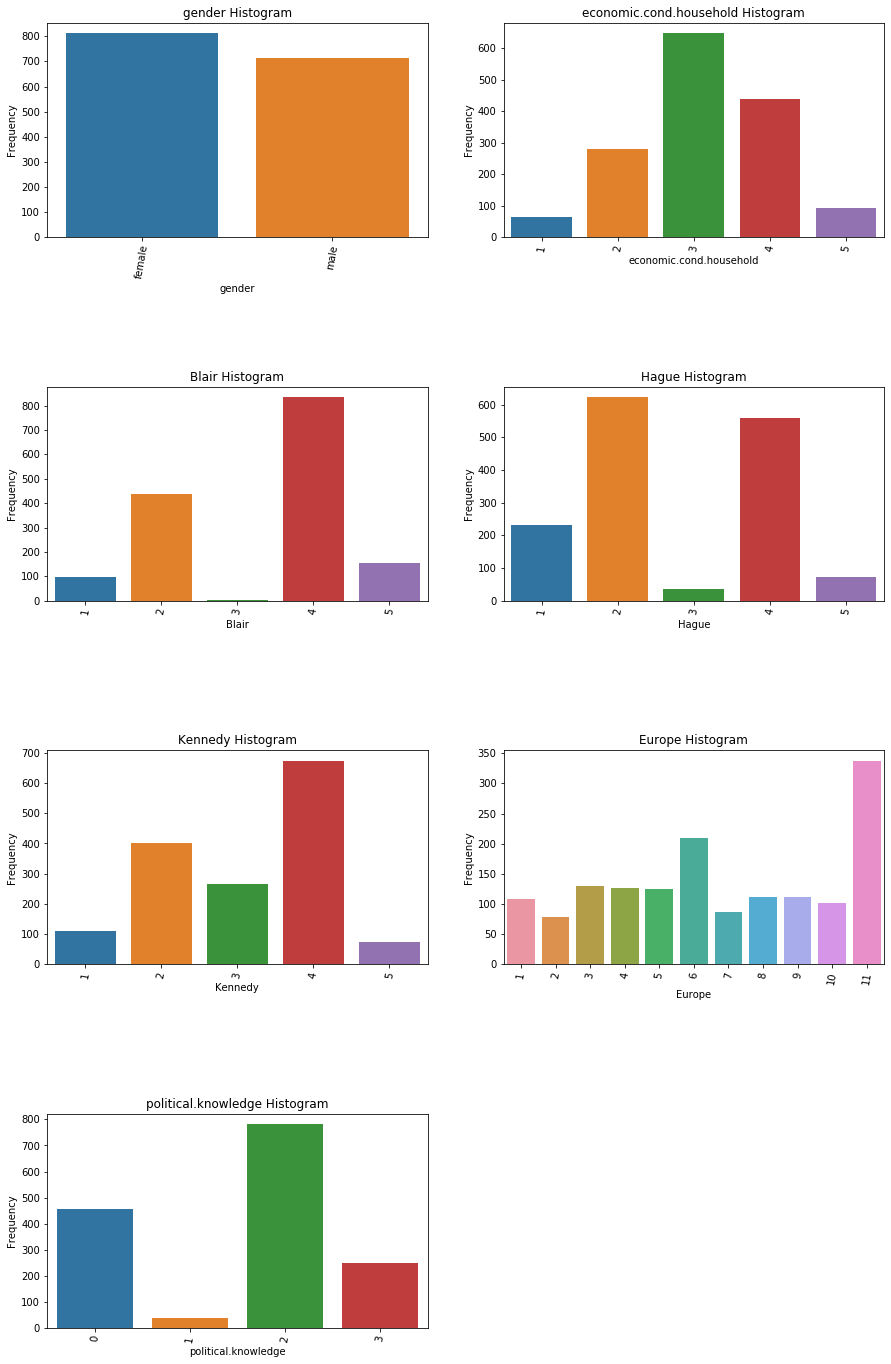

In [9]:
cat_cols = ['gender', 'economic.cond.household','Blair','Hague','Kennedy','Europe','political.knowledge']
fig_rows = np.ceil(len(cat_cols)/2)

plt.figure(figsize=(15, fig_rows*6))
plt.subplots_adjust(hspace=0.7)

for ind, col in enumerate(cat_cols):
    plt.subplot(fig_rows,2,ind+1)
    plt.title(col+' Histogram')
    ax = sns.countplot(df[col])
    ax.set(xlabel = col, ylabel='Frequency')
    xtickslabels=ax.get_xticklabels()
    ax.set_xticklabels(xtickslabels, rotation=80)
    # reduce number of ticks when too many
    if(len(xtickslabels)>20):
        for ind, label in enumerate(xtickslabels):
            if ind % 5 == 0:  # every 10th label is kept
                label.set_visible(True)
            else:
                label.set_visible(False)

# 3. Data Splitting

Split the dataset into 2 training and test datasets.

In [10]:
y = df.pop("vote")
X = df

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=8)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1067, 9)
(1067,)
(458, 9)
(458,)


# 4. Feature Engineering

## 4.1. Scaling numerical variables

In [12]:
SS = StandardScaler()
scaled_cols = ['age']

X_train[scaled_cols] = SS.fit_transform(X_train[scaled_cols])
X_test[scaled_cols] = SS.transform(X_test[scaled_cols])

## 4.2. Catagorical variables encoding

Convert catagorical columns into numerical columns using label encoding or one hot encoding.

In [13]:
OHE = OneHotEncoder(drop = None, handle_unknown='ignore', sparse=False)

# Define categorical to be one hot encoded
ohe_cols = ["gender"] 

# Encode categorical columns, and store results in a new dataframe
X_train_encoded = pd.DataFrame(OHE.fit_transform(X_train[ohe_cols]), index=X_train.index)
X_test_encoded = pd.DataFrame(OHE.transform(X_test[ohe_cols]), index=X_test.index)

# Retrieve encoded columns names
X_train_encoded.columns = OHE.get_feature_names(ohe_cols)
X_test_encoded.columns = OHE.get_feature_names(ohe_cols)

# Drop initial columns 
X_train.drop(ohe_cols ,axis=1, inplace=True)
X_test.drop(ohe_cols ,axis=1, inplace=True)

# Add encoded columns to initial dataset
X_train = pd.concat([X_train, X_train_encoded], axis=1)
X_test = pd.concat([X_test, X_test_encoded ], axis=1)

# 5. Logistic Regression

## Model Training

Fit a logistic regression model on the training set. Evaluate the model on the testing set. Use the F1score as an evaluation metric.

In [14]:
## training the model
## Let tune the 'penalty' and 'C' hyperparameters
param_grid = {'penalty': ['l1', 'l2', 'none'],
              'C': [0.001, 0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.2, 0.3, 0.5, 1, 10]}

logR = LogisticRegression(random_state=42, fit_intercept=True)
search = GridSearchCV(logR, param_grid, scoring='f1_macro', cv=5)
search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.2,
                               0.3, 0.5, 1, 10],
                         'penalty': ['l1', 'l2', 'none']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_macro', verbose=0)

The attribute "coef_" allows us to list the coefficients $\theta_1$, $\theta_2$, ... $\theta_{10}$ of our 10 features.

In [15]:
logR = search.best_estimator_
print(logR)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [16]:
logR.coef_

array([[ 0.20130428, -0.29420035, -0.0867341 , -0.4086557 ,  0.63813661,
        -0.28679496,  0.13601306,  0.20319581,  0.14091781, -0.08605036],
       [-0.13547911,  0.38119611,  0.13364671,  0.45164804, -0.3563134 ,
        -0.05756273, -0.08426419, -0.25090812, -0.23097939, -0.13993655],
       [-0.06582517, -0.08699576, -0.04691262, -0.04299233, -0.28182321,
         0.34435768, -0.05174887,  0.04771231,  0.09006157,  0.22598692]])

We can also get our intercept $\theta_0$ with the attribut "intercept_".

In [17]:
logR.intercept_

array([ 0.05486745, -0.37091594,  0.31604849])

## Model predictions

In [18]:
# predicting over training & testing datasets
y_train_pred = logR.predict(X_train)
y_test_pred = logR.predict(X_test)

Printing the first 10 predictions:

In [19]:
y_test_pred[:10]

array(['Labour', 'Labour', 'Labour', 'Conservative', 'Conservative',
       'Conservative', 'Conservative', 'Conservative', 'Conservative',
       'Labour'], dtype=object)

##  Model evaluation 

### Accuracy

There are other ways of measuring model performance (precision, recall, F1 Score, ROC Curve, etc). The accuracy is very simple to obtain. To get the mean accuracy on the given training dataset, we can use the method `score`:

In [20]:
logR.score(X_train, y_train)

0.6776007497656982

To get the mean accuracy on the given test dataset, we can also use the method `score`:

In [21]:
logR.score(X_test, y_test)

0.6768558951965066

### Confusion Matrix

In [22]:
metrics.confusion_matrix(y_test, y_test_pred)

array([[108,  26,   7],
       [ 23, 184,  12],
       [ 25,  55,  18]])

`scikit-learn` also offers a nice function to plot the confusion matrix.

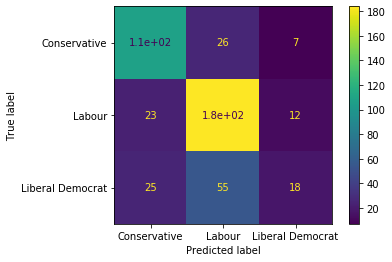

In [23]:
metrics.plot_confusion_matrix(logR, X_test, y_test)

### Recall

The recall of each class:

In [24]:
metrics.recall_score(y_test, y_test_pred, average=None)

array([0.76595745, 0.84018265, 0.18367347])

### Precision

The precision of each class:

In [25]:
metrics.precision_score(y_test, y_test_pred, average=None)

array([0.69230769, 0.69433962, 0.48648649])

### F1score

The f1score of each class:

In [26]:
metrics.f1_score(y_test, y_test_pred, average=None)

array([0.72727273, 0.76033058, 0.26666667])

### Macro F1score

In [27]:
metrics.f1_score(y_test, y_test_pred, average='macro')

0.5847566574839302

# 6. Decision Tree

## Building Decision Tree

Fit a decision tree model on the training set. Use cross-validation in order to tune the hyperparameters of the decision tree model. Evaluate the model on the testing set. Use the F1score as an evaluation metric.

In [28]:
## training the model
## Let tune the 'penalty' and 'C' hyperparameters
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [2, 4, 6, 8, 10],
              'min_samples_split': [5, 10, 15, 20, 50],
              'min_samples_leaf': [5, 10, 15, 20, 50]}

DecTree = DecisionTreeClassifier()
search = RandomizedSearchCV(DecTree, param_grid, scoring='f1_macro', cv=5, n_iter=400)
search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
          

Here's the optimal estimator:

In [29]:
DecTree = search.best_estimator_
print(DecTree)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


In [30]:
DecTree.classes_

array(['Conservative', 'Labour', 'Liberal Democrat'], dtype=object)

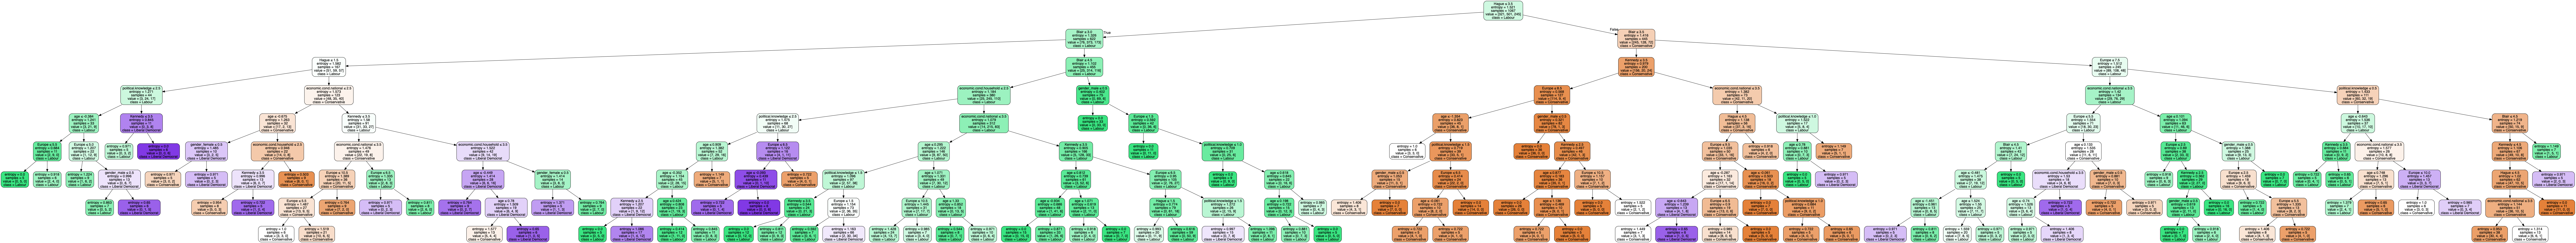

In [31]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(DecTree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X_train.columns, class_names=DecTree.classes_)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('safety_distance.png')
Image(graph.create_png())

## Optimized Model Evaluation

In [32]:
# predicting over training & testing datasets
y_train_pred = DecTree.predict(X_train)
y_test_pred = DecTree.predict(X_test)

Printing the first 10 predictions:

In [33]:
y_test_pred[:10]

array(['Labour', 'Labour', 'Labour', 'Conservative', 'Conservative',
       'Conservative', 'Conservative', 'Conservative', 'Conservative',
       'Labour'], dtype=object)

### Accuracy

There are other ways of measuring model performance (precision, recall, F1 Score, ROC Curve, etc). The accuracy is very simple to obtain. To get the mean accuracy on the given training dataset, we can use the method `score`:

In [34]:
DecTree.score(X_train, y_train)

0.7497656982193065

To get the mean accuracy on the given test dataset, we can also use the method `score`:

In [35]:
DecTree.score(X_test, y_test)

0.6462882096069869

### Confusion Matrix

In [36]:
metrics.confusion_matrix(y_test, y_test_pred)

array([[108,  20,  13],
       [ 33, 158,  28],
       [ 27,  41,  30]])

`scikit-learn` also offers a nice function to plot the confusion matrix.

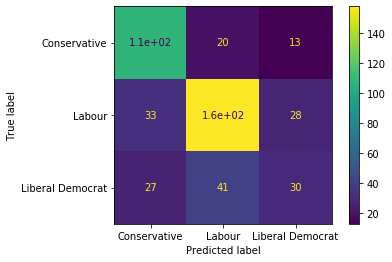

In [37]:
metrics.plot_confusion_matrix(DecTree, X_test, y_test)

### Recall

The recall of each class:

In [38]:
metrics.recall_score(y_test, y_test_pred, average=None)

array([0.76595745, 0.72146119, 0.30612245])

### Precision

The precision of each class:

In [39]:
metrics.precision_score(y_test, y_test_pred, average=None)

array([0.64285714, 0.72146119, 0.42253521])

### F1score

The f1score of each class:

In [40]:
metrics.f1_score(y_test, y_test_pred, average=None)

array([0.69902913, 0.72146119, 0.35502959])

### Macro F1score

In [41]:
metrics.f1_score(y_test, y_test_pred, average='macro')

0.5918399664090068

# 7. Random Forest

Fit a random forest model on the training set. Use cross-validation in order to tune the hyperparameters of the random forest model. Evaluate the model on the testing set. Use the F1score as an evaluation metric.

## Random Forest Classifier Training

In [42]:
# Create the random grid
random_grid = { # Number of trees in random forest
               'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 400, num = 8)],
                # Number of features to consider at every split
               'max_features': ['auto', 'sqrt', 'log2'],
                # Maximum number of levels in tree
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
                # Minimum number of samples required to split a node
               'min_samples_split': [2, 5, 10],
                # Minimum number of samples required at each leaf node
               'min_samples_leaf': [1, 2, 4],
                # Method of selecting samples for training each tree
               'bootstrap': [True, False]}

print(random_grid)
rf = RandomForestClassifier(criterion="gini", random_state=0)
rf_search = RandomizedSearchCV(estimator = rf, scoring='f1_macro', param_distributions = random_grid, n_iter = 20, cv = 3, verbose=1, random_state=0)
rf_search = rf_search.fit(X_train, y_train)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   23.2s finished


In [43]:
rf_search.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 110,
 'bootstrap': True}

## Random Forest Model Evaluation 

In [44]:
# predicting over training & testing datasets
y_train_pred = rf_search.predict(X_train)
y_test_pred = rf_search.predict(X_test)

#Printing the first 10 predictions:
y_test_pred[:10]

array(['Labour', 'Labour', 'Labour', 'Conservative', 'Conservative',
       'Conservative', 'Liberal Democrat', 'Conservative', 'Conservative',
       'Labour'], dtype=object)

### Accuracy

There are other ways of measuring model performance (precision, recall, F1 Score, ROC Curve, etc). The accuracy is very simple to obtain. To get the mean accuracy on the given training dataset, we can use the method `score`:

In [45]:
rf_search.score(X_train, y_train)

0.997978319783198

To get the mean accuracy on the given test dataset, we can also use the method `score`:

In [46]:
rf_search.score(X_test, y_test)

0.5655542288905551

### Confusion Matrix

In [47]:
metrics.confusion_matrix(y_test, y_test_pred)

array([[107,  25,   9],
       [ 21, 172,  26],
       [ 25,  55,  18]])

`scikit-learn` also offers a nice function to plot the confusion matrix.

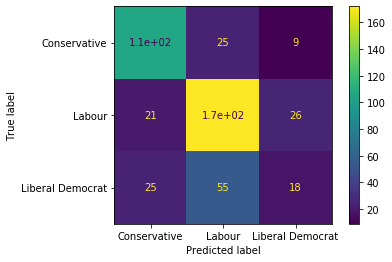

In [48]:
metrics.plot_confusion_matrix(rf_search, X_test, y_test)

### F1score

The f1score of each class:

In [49]:
metrics.f1_score(y_test, y_test_pred, average=None)

array([0.72789116, 0.73036093, 0.2384106 ])

### Macro F1score

In [50]:
metrics.f1_score(y_test, y_test_pred, average='macro')

0.5655542288905551

## Random Forest Feature Importance

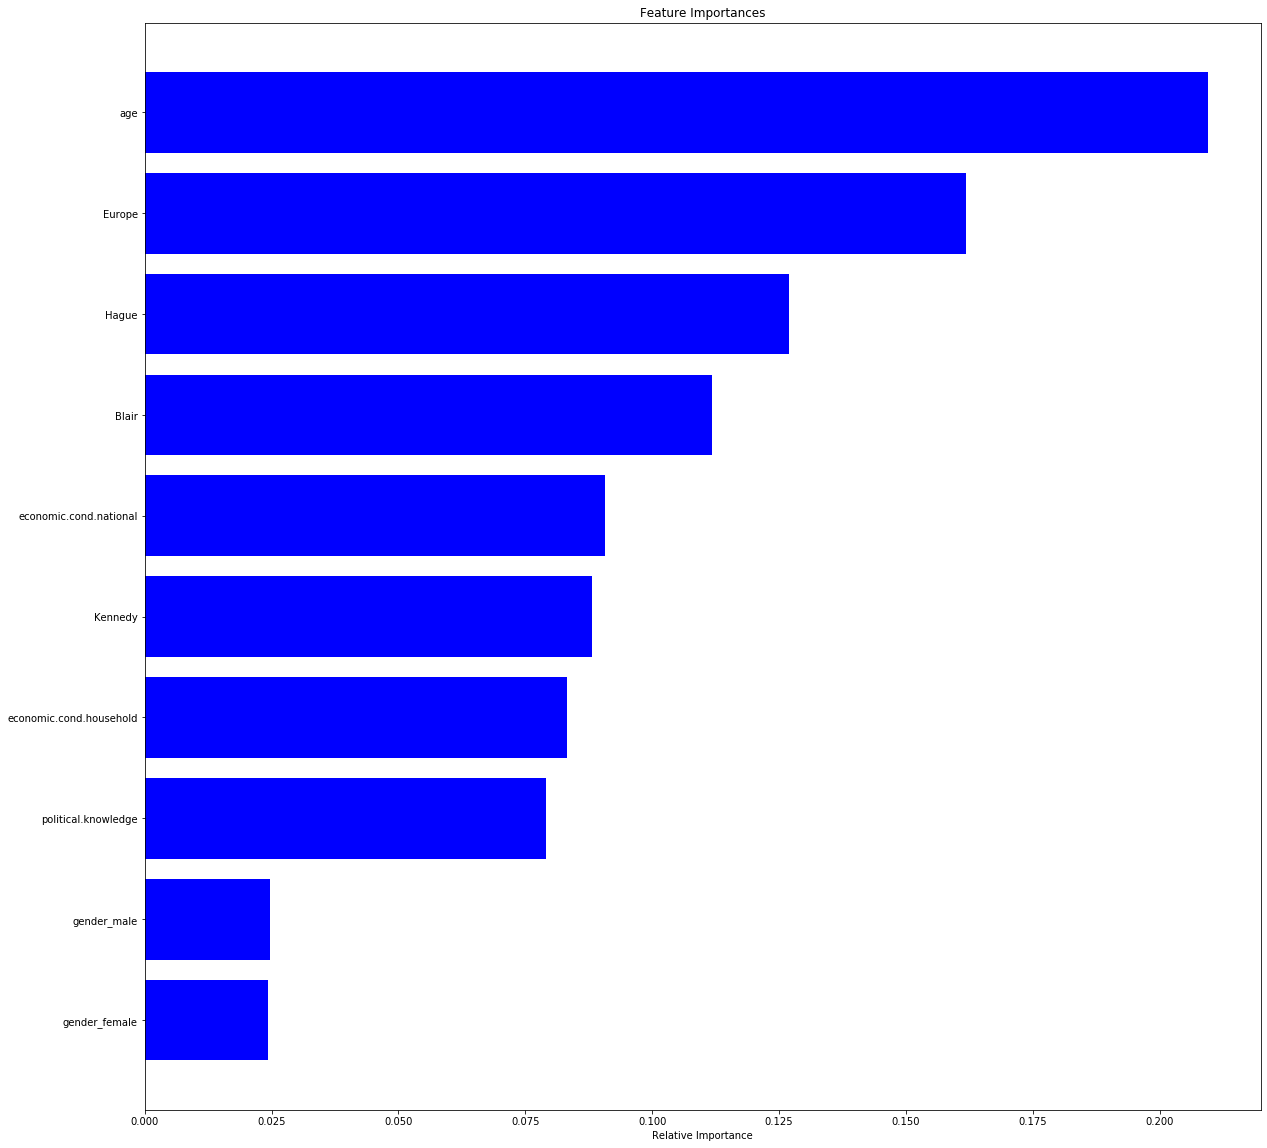

In [51]:
features = X_train.columns
importances = rf_search.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20, 20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# 8. Gradient Boosting

Fit a gradient boosting model on the training set. Use cross-validation in order to tune the hyperparameters of the gradient boosting model. Evaluate the model on the testing set. Use the F1score as an evaluation metric.

## Gradient Boost Classifier Training

In [52]:
param_grid = {"max_features": ["log2"],
              "max_depth": [5],
              "n_estimators": [300],
              "min_samples_split" : [7],
              'alpha': [10**i for i in np.arange(-4, 4, 2, dtype=float)]}

# Create the random grid
random_grid = { # Number of trees in gradient boost
               'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 400, num = 8)],
                # Number of features to consider at every split
               'max_features': ['auto', 'sqrt', 'log2'],
                # Maximum number of levels in tree
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
                # Minimum number of samples required to split a node
               'min_samples_split': [2, 5, 10],
                # Minimum number of samples required at each leaf node
               'min_samples_leaf': [1, 2, 4],
               'learning_rate': [0.1, 1],
               'subsample': [0.5, 0.7, 0.9]}

print(random_grid)
gb = GradientBoostingClassifier(random_state=0)
gb_search = RandomizedSearchCV(estimator = gb, scoring='f1_macro', param_distributions = random_grid, n_iter = 10, cv = 3, verbose=1, random_state=0)
gb_search = gb_search.fit(X_train, y_train)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'learning_rate': [0.1, 1], 'subsample': [0.5, 0.7, 0.9]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.2min finished


In [53]:
gb_search.best_params_

{'subsample': 0.9,
 'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 70,
 'learning_rate': 0.1}

## Gradient Boosting Model Evaluation 

In [54]:
# predicting over training & testing datasets
y_train_pred = gb_search.predict(X_train)
y_test_pred = gb_search.predict(X_test)

##  Model evaluation 

### Accuracy

There are other ways of measuring model performance (precision, recall, F1 Score, ROC Curve, etc). The accuracy is very simple to obtain. To get the mean accuracy on the given training dataset, we can use the method `score`:

In [55]:
gb_search.score(X_train, y_train)

0.997978319783198

To get the mean accuracy on the given test dataset, we can also use the method `score`:

In [56]:
gb_search.score(X_test, y_test)

0.5709997285830709

### Confusion Matrix

In [57]:
metrics.confusion_matrix(y_test, y_test_pred)

array([[103,  29,   9],
       [ 22, 162,  35],
       [ 27,  46,  25]])

`scikit-learn` also offers a nice function to plot the confusion matrix.

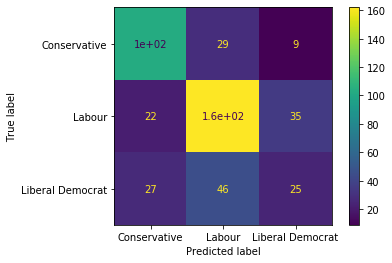

In [58]:
metrics.plot_confusion_matrix(gb_search, X_test, y_test)

### F1score

The f1score of each class:

In [59]:
metrics.f1_score(y_test, y_test_pred, average=None)

array([0.70307167, 0.71052632, 0.2994012 ])

### Macro F1score

In [60]:
metrics.f1_score(y_test, y_test_pred, average='macro')

0.5709997285830709